In [1]:
#Standard python and visualization libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go 
import urllib.request  
import webbrowser

#data scaling libraries
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#Clustering libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

#Kaggle download dataset libraries
import opendatasets as od

In [2]:
def get_spotify_data_from_kaggle():
    kaggle_credentials = {"username":"induvarshini",
                          "key":"fb1d0cfa2d2aed56b9923396fce076db"}
    
    od.download('https://www.kaggle.com/datasets/salvatorerastelli/spotify-and-youtube')
    data_file = ('spotify-and-youtube/Spotify_Youtube.csv')
    spotify_data = pd.read_csv(data_file, index_col=0)
    
    print("Data Read from Kaggle successfully!")

    return spotify_data

In [3]:
def combine_with_api_data(df):
    
    df_api = pd.read_csv("spotify_playlist_api_data_800.csv")
    df_api = df_api[['track_id', 'track_url', 'danceability', 'energy', 'key',
                     'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo', 'duration_ms']]
    
    df_api.rename(columns={"track_id": "uri", "track_url": "url_spotify"}, inplace = True)
    
    final_df = pd.concat([df, df_api])
    
    return final_df

In [4]:
def data_preparation(df):
    
    '''
    data_preparation():
    
    1. Change the column names to lowercase
    
    2. We see that most of the null values are in the youtube links of the spotify songs. 
    But on the spotify part we don't have much null values. So, let's drop the youtube columns.
    
    3. Extracting only the URI for the track
    
    4. Modifying the Spotify URL for the tracks
    
    5. To enable simplicity of the clustering only with audio features of the track, 
        we drop the album features 'artist', 'track', 'album', 'album_type'
        
    6. Drop any duplicates and keep the only the latest one
    
    7. Drop records if any column is null and reset the index
    
    8. Return the cleaned dataframe
    
    '''
    
    df.columns= df.columns.str.lower()
    
    temp_df = df.drop(columns = ['url_youtube', 'title', 'channel', 
                       'views', 'likes','comments', 'description',
                       'licensed', 'official_video', 'stream'])
    
    temp_df['uri'] = temp_df['uri'].apply(lambda s: s.split(":")[-1])
    
    temp_df['url_spotify'] = "https://open.spotify.com/track/" + temp_df['uri']
    
    temp_df = temp_df.drop(columns = ['artist','track', 'album', 'album_type'])
    
    temp_df = combine_with_api_data(temp_df)
    
    temp_df = temp_df.drop_duplicates(keep='last')
    
    temp_df = temp_df.dropna(how='any').reset_index(drop = True)
    
    print("Data Preparation done successfully!")
    print(temp_df.info())
    
    return temp_df
    

In [5]:
def eda_visualization(df):
    
    '''
    eda_visualization():
    
    1. Plot the violinplot for each audio feature in the data
    
    2. Plot correlation heatmap for the audio features
    
    3. Dataset description
    '''
    sns.set(style="whitegrid")
    
    #Violin Plot
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))
    axes = axes.flatten()

    for i, feature in enumerate(df.iloc[:, 2:].columns):
        sns.violinplot(x=df[feature], ax=axes[i], palette="Set3")

    plt.savefig("ViolinPlots_AudioFeatures.png")
    print("Violin Plots of Audio features saved successfully!")
    plt.close()
    
    #Correlation Plot
    corr = df.iloc[:, 2:].corr()
    f, ax = plt.subplots(figsize=(15,15))

    sns.heatmap(corr, square=True, linecolor='white', vmax=1.0, annot=True)
    plt.savefig("Correlation_AudioFeatures.png")
    print("Correlation Heatmap of Audio features saved successfully!")
    plt.close()
    
    
    #Summary statistics of the data
    print(df.iloc[:, 2:].describe())
    
    return None

In [6]:
def perform_pca(df):
    
    '''
    perform_pca():
    
    1. Scale the numeric columns in the data using Standard Scaler
    
    2. Prepare the scaled dataframe combining the URI and URL columns
    
    3. Apply PCA with n = 5
    
    4. Get scores for the Principal Components and Store it in a dataframe
    
    5. Get the explained variance for each PC
    
    6. Get the cumulative variance after each PC and print the cumulative variance
    
    7. Return the cumulative variance dataframe, scaled dataframe and pc array
    
    '''
   
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df.iloc[:,2:])
    
    scaled_df = pd.concat([df.iloc[:,:2],
                           pd.DataFrame(scaled_array, 
                                        columns = ['danceability', 'energy', 'key', 
                                                   'loudness','speechiness', 'acousticness',
                                                   'instrumentalness','liveness','valence',
                                                   'tempo', 'duration_ms'])], axis = 1)
    
    pca = PCA(n_components = 8)
    pca.fit(scaled_array)
    
    scores = pca.transform(scaled_array)
    scores_df = pd.DataFrame(scores, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
    
    explained_variance = pca.explained_variance_ratio_
    explained_variance = np.insert(explained_variance, 0,0)

    cumulative_variance = np.cumsum(np.round(explained_variance, decimals = 4))

    df_cumulative_variance = pd.DataFrame({'Principal Components':['Origin','PC 1','PC 2','PC 3','PC 4',
                                                               'PC 5', 'PC 6','PC 7','PC 8'], 
                                      "Explained Variance": explained_variance,
                                      "Cumulative Variance": cumulative_variance})
    
    print("PCA performed successfully!")
    return df_cumulative_variance, scaled_df, scores_df
    

In [7]:
def perform_kmeans(scaled_df):
    
    '''
    perform_kmeans():
    
    1. Run KMeans Elbow Visualizer to find the optimal number of Clusters
    
    2. Clustering using K Means 
    
    3. Get the clusters for each data point and the clusters' centers
    
    4. Plot the clusters and centers with first two audio features along X and Y axis
    
    5. Return the clusters
    
    
    '''
    kmeans = KMeans()
    elbow = KElbowVisualizer(kmeans, k=(2,10))
    elbow.fit(scaled_df.iloc[:,2:])
    elbow.show()
    
    #creating the K means model with K = 5 - optimal number of clusters after the elbow plot
    kmeans = KMeans(n_clusters=5)
    k_fit = kmeans.fit(scaled_df.iloc[:,2:])

    #finding the clusters of each data point and centroids
    clusters = k_fit.labels_
    centers = k_fit.cluster_centers_
    
    print("K means clustering performed successfully!")
    
    #Plot the clusters and centers with first two audio features along X and Y axis
    plt.scatter(scaled_df.iloc[:,2],scaled_df.iloc[:,3],c=clusters, s=50,cmap="plasma")
    plt.scatter(centers[:, 0],centers[:, 1],c="red", s=100,alpha=0.8)
    plt.savefig("Kmeans_Clustering.png")
    
    print("K Means Clusters displayed!")
    plt.close()
    
    return clusters

In [8]:
def save_as_playlists(df):
    
    '''
    Bucketing Emotions:
    
    Cluster 0. Happy, Calm

    Cluster 1. Surprise

    Cluster 2. Sad, Fearful

    Cluster 3. Angry, Disgust

    Cluster 4. Neutral
    
    1. Save each cluster URLs in different file
    
    '''
    
    for i in df['clusters'].unique():
        df[df['clusters'] == i]['url_spotify'].to_csv(f"cluster{i}_urls.csv", index = False)
        print(f'File cluster{i}_urls.csv saved successfully!')

In [9]:
def recommend_songs(emotion):
    
    '''
    recommend_songs():
    
    1. Map each emotion to a cluster number
    
    2. Read the respective cluster urls
    
    3. Pick 5 urls and open it for the user
    
    '''
    emotion_to_cluster_mapping= {'happy': 0, 'calm': 0, 
                                 'surprise': 1, 
                                 'sad': 2, 'fearful': 2, 
                                 'angry': 3, 'disgust': 3, 
                                 'neutral': 4
                                }
    
    print("Emotion mapped to cluster successfully!")
    cluster_number = emotion_to_cluster_mapping[emotion]
    
    cluster_urls = pd.read_csv(f"cluster{cluster_number}_urls.csv")
    
    recommended_songs_links = list(cluster_urls['url_spotify'].sample(n=5))
    
    print("Here are your Spotify Recommendations: ")
    print(recommended_songs_links)
    
    print("Opening the Spotify links in your default browser")
    #open the urls in the web browser
    for i in range(0,5):
        webbrowser.open(recommended_songs_links[i])

In [10]:
def main(emotion):
    raw_data = get_spotify_data_from_kaggle()
    
    data = data_preparation(raw_data)
    
    cum_variance_pca, scaled_data, pc_array = perform_pca(data)
    
    eda_visualization(scaled_data)
    
    data_clusters = perform_kmeans(scaled_data)
    
    data['clusters'] = data_clusters.tolist()
    
    data.to_csv("final_data_after_clustering.csv", index = False)
    
    save_as_playlists(data)
    recommend_songs(emotion)
    
#     90% of the variance is achieved only after choosing 8 PCs and we have 10 features. 
#     Let's move on without proceeding using the PCs
    
    return data

Skipping, found downloaded files in "./spotify-and-youtube" (use force=True to force download)
Data Read from Kaggle successfully!
Data Preparation done successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19570 entries, 0 to 19569
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url_spotify       19570 non-null  object 
 1   uri               19570 non-null  object 
 2   danceability      19570 non-null  float64
 3   energy            19570 non-null  float64
 4   key               19570 non-null  float64
 5   loudness          19570 non-null  float64
 6   speechiness       19570 non-null  float64
 7   acousticness      19570 non-null  float64
 8   instrumentalness  19570 non-null  float64
 9   liveness          19570 non-null  float64
 10  valence           19570 non-null  float64
 11  tempo             19570 non-null  float64
 12  duration_ms       19570 non-null  float64
dtypes: float64(11)

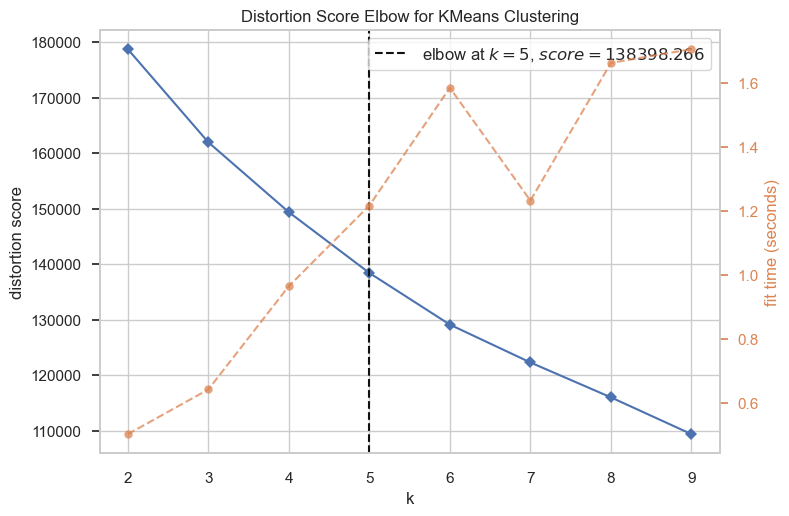

K means clustering performed successfully!
K Means Clusters displayed!
File cluster3_urls.csv saved successfully!
File cluster0_urls.csv saved successfully!
File cluster1_urls.csv saved successfully!
File cluster2_urls.csv saved successfully!
File cluster4_urls.csv saved successfully!
Emotion mapped to cluster successfully!
Here are your Spotify Recommendations: 
['https://open.spotify.com/track/5SCB7L1alKg7ZEeSw7Sq9f', 'https://open.spotify.com/track/7MTU9sI9DuOX4cabpy7sVy', 'https://open.spotify.com/track/7hn8Q8WAxFdL4aZ159GI7C', 'https://open.spotify.com/track/4sIkDCqNjTubfb5UVs8lEA', 'https://open.spotify.com/track/4lO57zZGFcj7vSY4QhfVDq']
Opening the Spotify links in your default browser


'\nkaggle_credentials = {"username":"induvarshini",\n                          "key":"fb1d0cfa2d2aed56b9923396fce076db"}\n'

In [11]:
#Getting this emotion from CNN model
emotion_detected = 'surprise'
df = main(emotion_detected)

'''
kaggle_credentials = {"username":"induvarshini",
                          "key":"fb1d0cfa2d2aed56b9923396fce076db"}
'''

References:
1. https://medium.com/@chiragsaraogi1990/detecting-song-emotions-using-k-means-clustering-and-xgboost-7424999bf067#:~:text=Detecting%20Song%20Emotions%20using%20K%2DMeans%20Clustering%20and%20XGBoost,-Chirag%20Saraogi&text=As%20an%20avid%20user%20of,my%20musical%20tastes%20and%20preferences.

2. https://towardsdatascience.com/k-means-clustering-using-spotify-song-features-9eb7d53d105c